### Approximating sine function on [-1, 1] with piecewise polynomial

In [1]:
from psiqworkbench import QPU, QFixed
from psiqworkbench.filter_presets import BIT_DEFAULT
from qmath.poly import EvalFunctionPPA

import numpy as np
from matplotlib import pyplot as plt
import functools

interval = (-1, 1)

# Approximates sine function using fixed-precision numbers with `radix` fractional 
# bits and piecewise approximation with tolerance 2^-radix.
# Reports resulting error (max error measured at 21 points) and metrics from last experiment.
@functools.cache
def run_experiment(radix, degree):
    func = EvalFunctionPPA(np.sin, interval=interval, degree=degree, error_tol=2**(-radix))
    errors = []
    metrics = []
    for x in np.linspace(interval[0], interval[1], 21):
        qpu = QPU(filters=BIT_DEFAULT)
        qpu.reset(500)
        qx = QFixed(radix+5,name="qx", radix=radix, qpu=qpu)
        qx.write(x)
        func.compute(qx)
        result = func.get_result_qreg().read()
        errors.append(np.abs(result - np.sin(x)))
        metrics.append(qpu.metrics())
    return {
        "error": max(errors),
        "metrics": metrics[-1],
        "num_pieces": len(func.poly.pieces),
    }

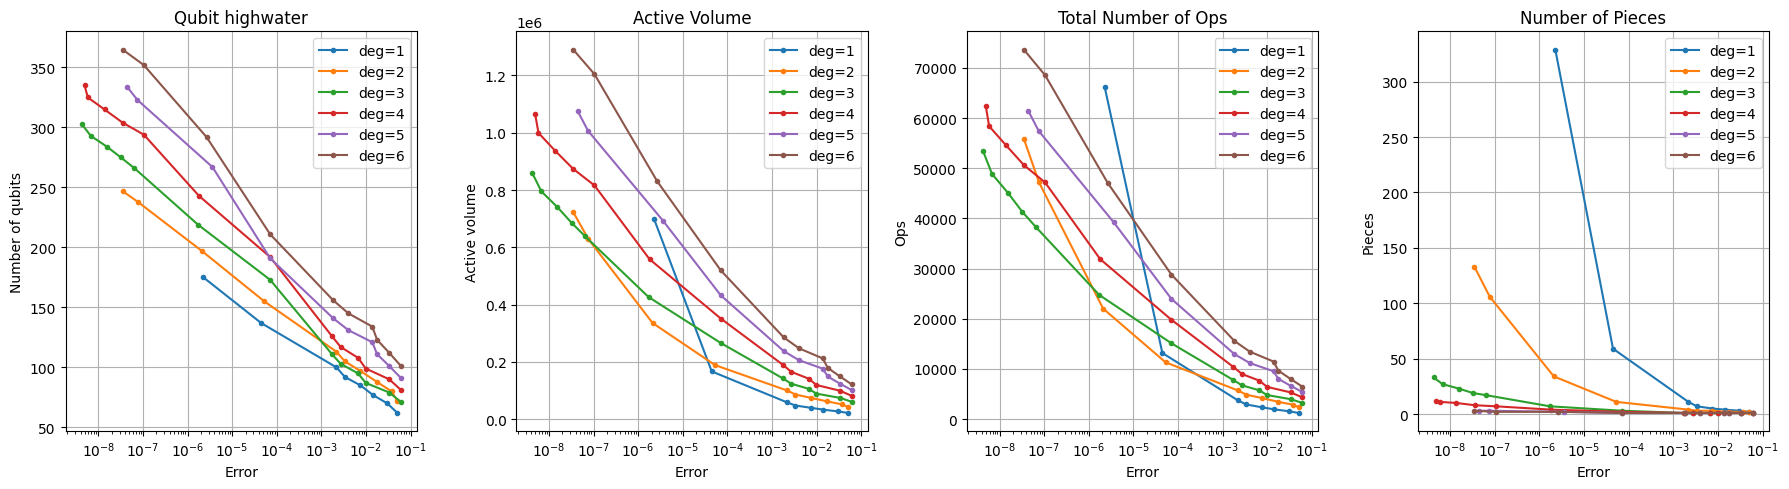

In [7]:
from matplotlib import pyplot as plt

radix_range = [5, 6, 7, 8, 9, 10, 15, 20, 25, 26, 27, 28, 29]
degree_range = [1, 2, 3, 4, 5, 6]

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for degree in degree_range:
    errors = []
    num_pieces = []
    active_volume = []
    total_num_ops = []
    qubit_highwater = []

    for radix in radix_range:
        if degree == 1 and radix>20:
            continue
        if degree not in [3, 4] and radix > 26:
            continue
        #print(degree, radix)
        results = run_experiment(radix, degree)
        errors.append(results["error"])
        num_pieces.append(results["num_pieces"])
        active_volume.append(results["metrics"]["active_volume"])
        total_num_ops.append(results["metrics"]["total_num_ops"])
        qubit_highwater.append(results["metrics"]["qubit_highwater"])

    axes[0].plot(errors, qubit_highwater, label=f"deg={degree}", marker='.')
    axes[1].plot(errors, active_volume, label=f"deg={degree}", marker='.')
    axes[2].plot(errors, total_num_ops, label=f"deg={degree}", marker='.')
    axes[3].plot(errors, num_pieces, label=f"deg={degree}", marker='.')

for ax, title, ylabel in [
    (axes[0], "Qubit highwater", "Number of qubits"),
    (axes[1], "Active Volume", "Active volume"),
    (axes[2], "Total Number of Ops", "Ops"),
    (axes[3], "Number of Pieces", "Pieces"),
]:
    ax.set_xscale("log")
    ax.set_xlabel("Error")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()